In [2]:
# Prerequisites:
#   - Install NVIDIA driver (I installed latest studio driver)
#   - Install CUDA toolkit (I installed 12.1 for WSL2)
# Check if NVIDIA and CUDA are working -> should output table with driver and CUDA versions
!nvidia-smi

Tue Mar  5 20:49:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8             12W /   60W |    2735MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# General imports
import os
import urllib.request

In [4]:
# Make sure this runs first and is not overriden later in notebook 
HOME = os.getcwd()
print(HOME)

/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts


In [5]:
# -------- Uncomment below to clone GroundingDINO repository (only need to do once) -----------
# %cd {HOME}
# !git clone https://github.com/idea-research/groundingdino.git

# -------- Uncomment below to install GroundingDINO Python dependencies (only need to do once) ------------
# %cd {HOME}/GroundingDINO
# %pip install -e .

# CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py")
print(CONFIG_PATH, " exists: ", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME = "groundingdino_swinb_cogcoor.pth"
# ------------ Uncomment below to install GroundingDINO weights to /weights folder (only need to do once) -----------
# %cd {HOME}
# !mkdir {HOME}/weights
# %cd {HOME}/weights
# WEIGHTS_FILE = os.path.join(HOME, "weights", WEIGHTS_NAME)
# urllib.request.urlretrieve("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth", WEIGHTS_FILE)

WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, " exists: ", os.path.isfile(WEIGHTS_PATH))

/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py  exists:  True
/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/weights/groundingdino_swinb_cogcoor.pth  exists:  True


In [6]:
# GroundingDINO imports
import matplotlib.pyplot as plt
import torch
import cv2
import time

In [7]:
# Load GroundingDINO model, takes a bit
from groundingdino.util.inference import load_model, load_image, predict, annotate
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/venv/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/venv/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/mnt/d/Computer Science/Unity projects/VisualGeneration/object_detection_scripts/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradie

front toaster lever: confidence 0.5722686648368835, box [588.0275268554688, 822.054931640625, 1165.7996826171875, 1632.1279296875]
fronter lever: confidence 0.35494890809059143, box [580.7589111328125, 1305.765380859375, 248.7866973876953, 241.05270385742188]


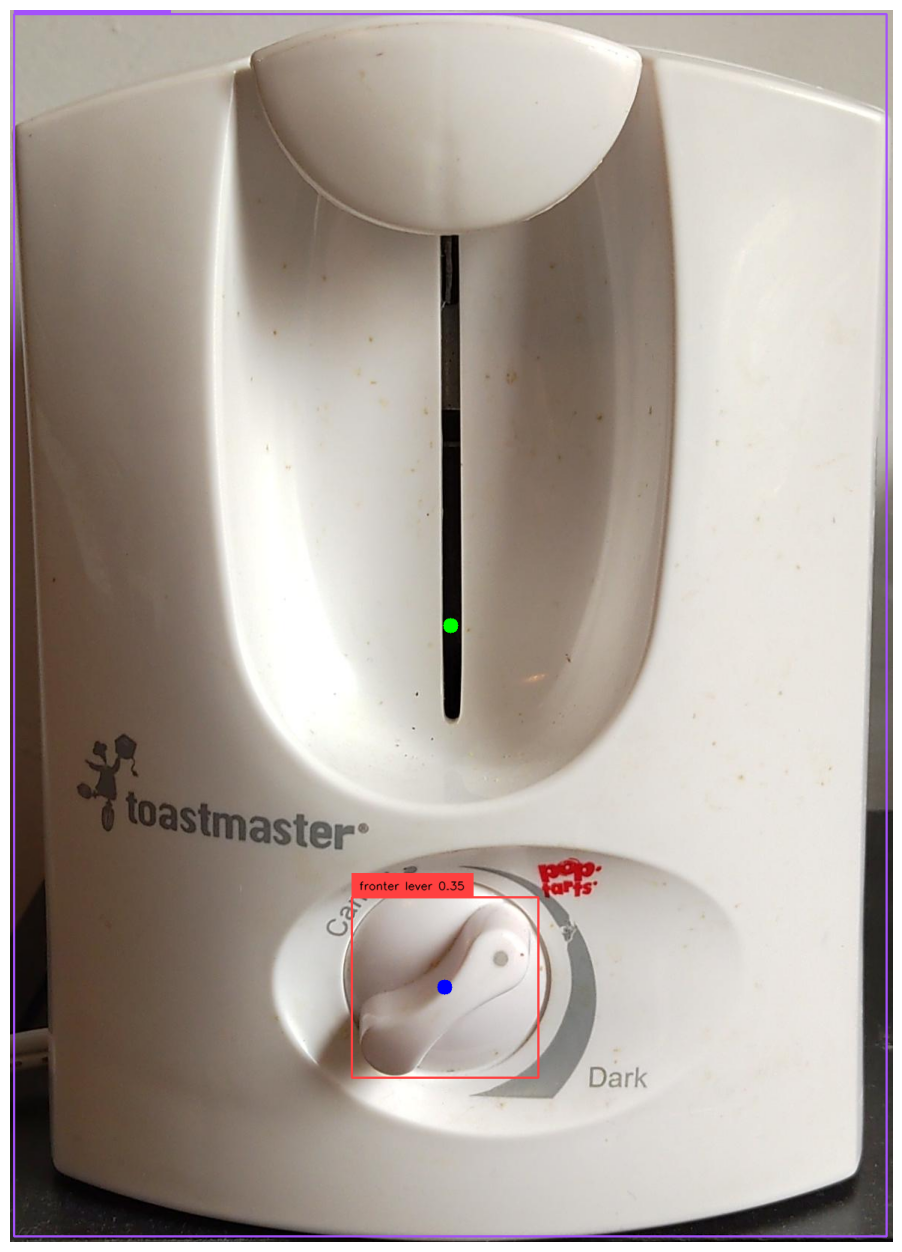

3.347686529159546 sec


In [8]:
# ------------- Testing GroundingDINO on an image -------------------
# IMAGE_NAME = "HL_microwave_close.jpg"
IMAGE_NAME = "cropped_image_03-05_20-47-51.jpg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

image_source, image = load_image(IMAGE_PATH)
img_h = image_source.shape[0]
img_w = image_source.shape[1]

begin = time.time()
# TEXT_PROMPT = "button"
# TEXT_PROMPT = "right side power button"
# TEXT_PROMPT = "center light switch"
# TEXT_PROMPT = "Left knob"
TEXT_PROMPT = "front toaster lever"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.3

# Tensor of found boxes (with confidence above box_threshold)
# Tensor of logits for text phrases
# List[str] of phrases from prompt found corresponding to boxes (with confidence above text_threshold)
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
# print(phrases)

# Get box coordinates
scale_fct = torch.Tensor([img_w, img_h, img_w, img_h])
boxes = boxes * scale_fct

if(boxes.numel() == 0):
   print('No objects detected.')
# Output details for each detection:
for box, confidence, phrase in zip(boxes, logits, phrases):
    print(f'{phrase}: confidence {confidence}, box {box.tolist()}')
# print(boxes)
# print(logits)
# print(phrases)

_, best_box, _ = max(zip(logits, boxes, phrases), key=lambda x: x[0])

for box in boxes:
  # Draw blue circle as center of each box (0, 0) is top-left of image
  annotated_frame = cv2.circle(annotated_frame, (int(box[0]), int(box[1])), 10, (255, 0, 0), -1)

# Color best box with a green dot
annotated_frame = cv2.circle(annotated_frame, (int(best_box[0]), int(best_box[1])), 10, (0, 255, 0), -1)

%matplotlib inline
# sv.plot_image(annotated_frame, (16, 16))
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()
print(f'{time.time() - begin} sec')